In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Load the dataset
file_path = 'Food_and_Nutrition.csv'  
data = pd.read_csv(file_path)

In [3]:

# Identify categorical columns
categorical_cols = data.select_dtypes(include='object').columns

In [4]:
# Apply Label Encoding to convert categorical data into numeric form
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = data[col].astype(str)  # Ensure all data is string before encoding
    data[col] = label_encoder.fit_transform(data[col])

In [5]:
missing_data = data.isnull().sum()
missing_columns = missing_data[missing_data > 0]
print("Columns with Missing Data:")
print(missing_columns)


Columns with Missing Data:
Daily_Calorie_Target    2
Protein                 1
Sugar                   4
Sodium                  3
Calories                2
Carbohydrates           1
dtype: int64


In [6]:
# Percentage of missing values per column
data.isnull().mean() * 100


Ages                    0.000000
Gender                  0.000000
Height                  0.000000
Weight                  0.000000
Activity_Level          0.000000
Dietary_Preference      0.000000
Daily_Calorie_Target    0.117786
Protein                 0.058893
Sugar                   0.235571
Sodium                  0.176678
Calories                0.117786
Carbohydrates           0.058893
Fiber                   0.000000
Fat                     0.000000
Breakfast_Suggestion    0.000000
Lunch_Suggestion        0.000000
Snack_Suggestion        0.000000
Dinner_Suggestion       0.000000
Disease                 0.000000
dtype: float64

In [7]:
# Split dataset into features and target
X = data.drop(columns='Daily_Calorie_Target')
y = data['Daily_Calorie_Target']

In [8]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Combine X_train and y_train for imputation
train_data = pd.concat([X_train, y_train], axis=1)

In [10]:
# Apply Iterative Imputer
iter_imputer = IterativeImputer(random_state=42)
train_data_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(train_data), columns=train_data.columns)


c:\Users\Syeda Mehak Zahra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
# Check for missing values after imputation
print("Missing Values After Iterative Imputation:\n", train_data_iter_imputed.isnull().sum())

Missing Values After Iterative Imputation:
 Ages                    0
Gender                  0
Height                  0
Weight                  0
Activity_Level          0
Dietary_Preference      0
Protein                 0
Sugar                   0
Sodium                  0
Calories                0
Carbohydrates           0
Fiber                   0
Fat                     0
Breakfast_Suggestion    0
Lunch_Suggestion        0
Snack_Suggestion        0
Dinner_Suggestion       0
Disease                 0
Daily_Calorie_Target    0
dtype: int64


In [12]:
# Replace original training data with Iterative Imputer results
data.update(train_data_iter_imputed)


In [13]:
# Save the updated DataFrame to a new CSV file
data.to_csv('Missing_data_food&_Nutrition.csv', index=False)
print("Missing data has been saved handled!")


Missing data has been saved handled!


In [14]:
# Assuming the dataset is named 'data' and contains numerical columns
numerical_cols = data.select_dtypes(include='number')

In [15]:
 #Calculate skewness for each numerical column
skewness = numerical_cols.skew()


In [16]:
#Display the skewness for each numerical column
skewness

Ages                     0.157585
Gender                   0.016505
Height                   0.084227
Weight                   0.228899
Activity_Level          -0.211837
Dietary_Preference      -0.196832
Daily_Calorie_Target     0.345640
Protein                  0.362170
Sugar                    0.289450
Sodium                 -41.206796
Calories               -41.206796
Carbohydrates            0.512206
Fiber                    0.287235
Fat                      0.261982
Breakfast_Suggestion    -0.129258
Lunch_Suggestion         1.101071
Snack_Suggestion         0.396130
Dinner_Suggestion       -0.243729
Disease                 -4.004116
dtype: float64

In [17]:

# Calculate skewness for each numeric column
skewness = data.select_dtypes(include='number').skew()

In [18]:
# Define the threshold for mild skewness (you can adjust this value)
mild_skew_threshold = 0.5  # Anything below this value will use Z-score

In [19]:
# Identify columns with mild skewness (Z-score method) and high skewness (IQR method)
mild_skewed_cols = skewness[abs(skewness) < mild_skew_threshold].index
highly_skewed_cols = skewness[abs(skewness) >= mild_skew_threshold].index

In [20]:
# Display the results
print("Columns with Mild Skewness (Z-score Method):")
print(mild_skewed_cols)

print("\nColumns with High Skewness (IQR Method):")
print(highly_skewed_cols)

Columns with Mild Skewness (Z-score Method):
Index(['Ages', 'Gender', 'Height', 'Weight', 'Activity_Level',
       'Dietary_Preference', 'Daily_Calorie_Target', 'Protein', 'Sugar',
       'Fiber', 'Fat', 'Breakfast_Suggestion', 'Snack_Suggestion',
       'Dinner_Suggestion'],
      dtype='object')

Columns with High Skewness (IQR Method):
Index(['Sodium', 'Calories', 'Carbohydrates', 'Lunch_Suggestion', 'Disease'], dtype='object')


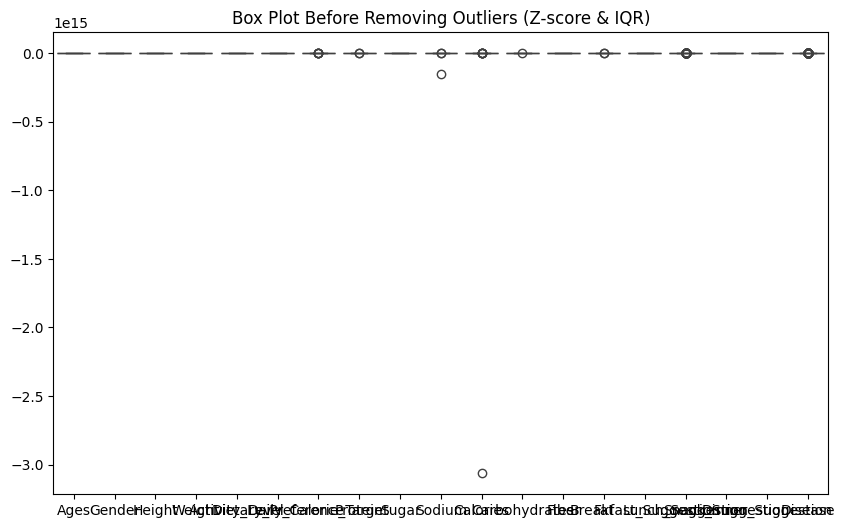

In [21]:
# Box plot before removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data.select_dtypes(include=np.number))
plt.title("Box Plot Before Removing Outliers (Z-score & IQR)")
plt.show()

In [22]:
# Apply Z-score Method to Columns with Mild Skewness
# Calculate Z-scores for each numeric column
z_scores = np.abs(zscore(data[mild_skewed_cols]))

In [23]:
# Set a threshold for the Z-score (commonly 3)
threshold = 3

In [24]:
# Filter out outliers based on Z-score for mild skewed columns
data_zscore_cleaned = data[(z_scores < threshold).all(axis=1)]

In [25]:
# Apply IQR Method to Columns with High Skewness
# Calculate IQR for each numeric column with high skewness
Q1 = data[highly_skewed_cols].quantile(0.25)
Q3 = data[highly_skewed_cols].quantile(0.75)
IQR = Q3 - Q1

In [26]:
# Set the lower and upper bounds to filter out the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [27]:
# Filter out outliers based on IQR for highly skewed columns
data_iqr_cleaned = data[~((data[highly_skewed_cols] < lower_bound) | (data[highly_skewed_cols] > upper_bound)).any(axis=1)]

In [28]:
# Combine the cleaned data from both methods
# Since we've cleaned separately for each method, we need to combine the results
final_cleaned_data = data_zscore_cleaned.merge(data_iqr_cleaned, how='inner')

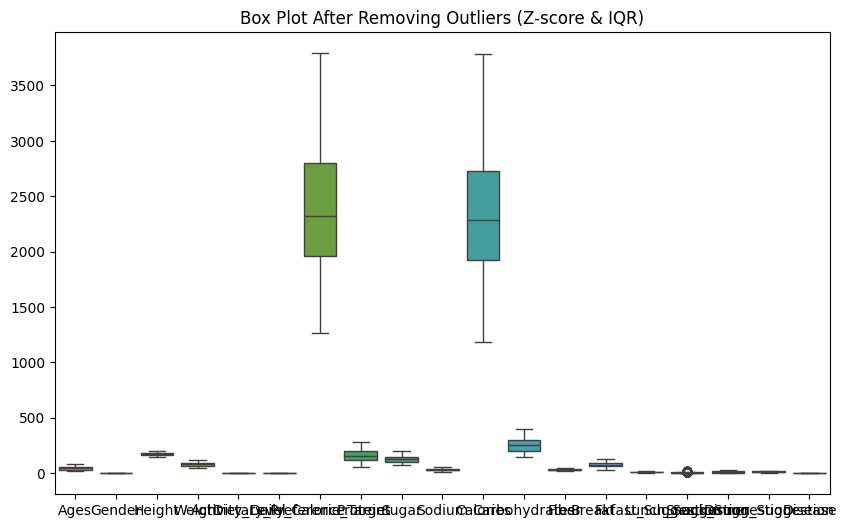

In [29]:
# Box plot after removing outliers (Z-score and IQR)
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_cleaned_data.select_dtypes(include=np.number))
plt.title("Box Plot After Removing Outliers (Z-score & IQR)")
plt.show()

In [30]:
# Save the cleaned data to a CSV file after removing outliers
data_zscore_cleaned.merge(data_iqr_cleaned, how='inner').to_csv('outliers_removed.csv', index=False)


In [31]:

# Select numeric columns for scaling
numeric_coloumns= data.select_dtypes(include=np.number).columns

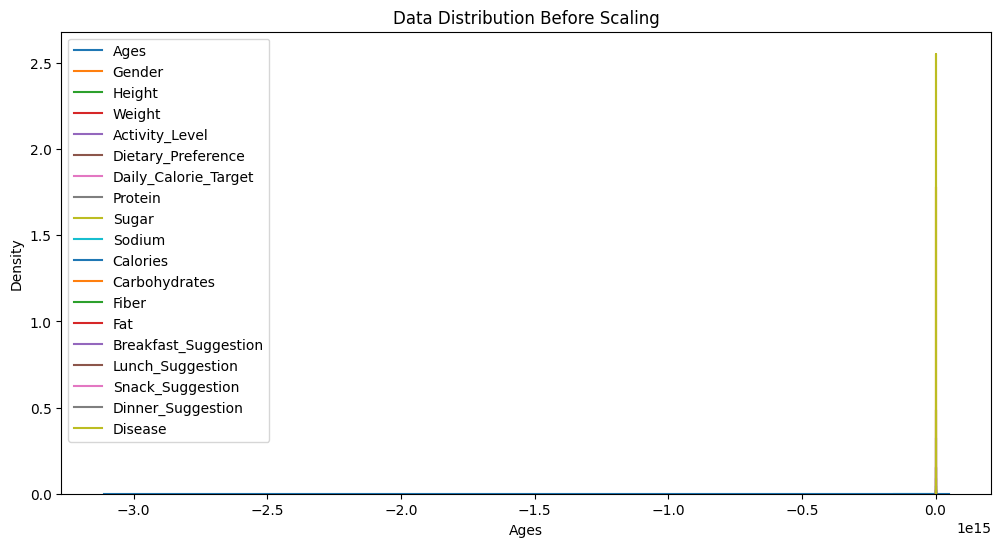

In [32]:
# Visualize the data before scaling
plt.figure(figsize=(12, 6))
plt.title("Data Distribution Before Scaling")
for col in numeric_coloumns:
    sns.kdeplot(data[col], label=col)
plt.legend()
plt.show()


In [33]:
# Apply StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_coloumns])


In [34]:
# Convert scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numeric_coloumns)

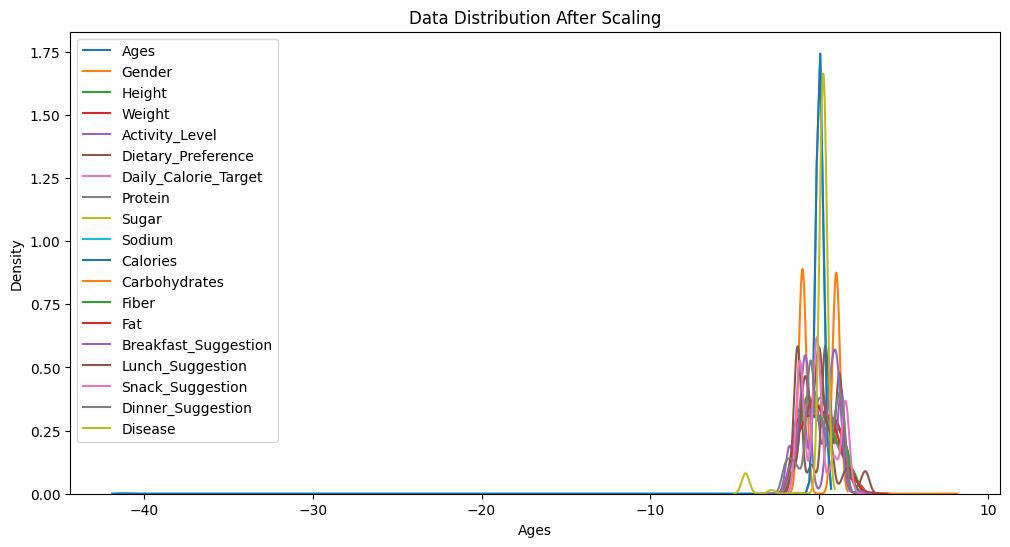

In [35]:
# Visualize the data after scaling
plt.figure(figsize=(12, 6))
plt.title("Data Distribution After Scaling")
for col in numeric_coloumns:
    sns.kdeplot(scaled_df[col], label=col)
plt.legend()
plt.show()

In [36]:
# Save the scaled data to a new CSV file
data_scaled = data.copy()
data_scaled[numeric_coloumns] = scaled_df
data_scaled.to_csv('Food_and_Nutrition_Scaled.csv', index=False)

In [37]:
print("Feature scaling applied and results saved to 'Food_and_Nutrition_Scaled.csv'.")

Feature scaling applied and results saved to 'Food_and_Nutrition_Scaled.csv'.


In [38]:
# Determine the optimal number of components
pca = PCA()
pca.fit(scaled_data)

PCA()

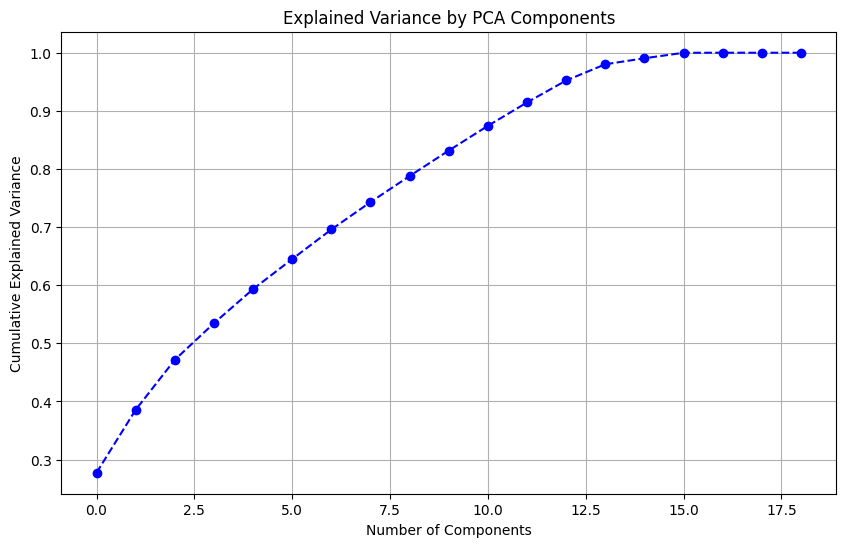

In [39]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [40]:
# Choose the number of components that explain at least 95% of the variance
explained_variance_threshold = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= explained_variance_threshold) + 1
print(f"Number of components explaining at least {explained_variance_threshold*100}% variance: {n_components}")

Number of components explaining at least 95.0% variance: 13


In [41]:
# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(scaled_data)

In [42]:
# Convert PCA-transformed data back to a DataFrame
pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

In [43]:
# Save the PCA-transformed data to a new CSV file
pca_df.to_csv('Food_and_Nutrition_PCA.csv', index=False)
print(f"PCA applied and results saved to 'Food_and_Nutrition_PCA.csv'.")

PCA applied and results saved to 'Food_and_Nutrition_PCA.csv'.


In [44]:
# Separate features and target
X = data.drop(columns='Daily_Calorie_Target')
y = data['Daily_Calorie_Target']

In [45]:
numerical_cols = X.select_dtypes(include='number').columns


In [46]:

# Separate features and target
X = data.drop(columns='Daily_Calorie_Target')
y = data['Daily_Calorie_Target']


In [47]:
# Identify numerical columns
numerical_cols = X.select_dtypes(include='number').columns

In [48]:
# Define preprocessing steps for numerical data
numerical_preprocessor = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),  # Impute missing values
    ('scaler', StandardScaler())  # Standardize the data
])

In [49]:
# Full Preprocessing Pipeline (with PCA)
full_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_preprocessor),
    ('pca', PCA(n_components=0.95))  # Retain 95% variance
])

In [50]:
# Basic Preprocessing Pipeline (without PCA)
basic_pipeline = Pipeline(steps=[
    ('preprocessor', numerical_preprocessor)
])

In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Define regression models to evaluate
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [53]:
# Function to evaluate regression models with a given pipeline
def evaluate_models(pipeline, X_train, X_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        model_pipeline = Pipeline(steps=[
            ('pipeline', pipeline),
            ('model', model)
        ])
        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"MSE": mse, "R²": r2}
    return results

In [54]:
# Evaluate with both preprocessing strategies
print("Evaluating models with full preprocessing (including PCA)...")
full_results = evaluate_models(full_pipeline, X_train, X_test, y_train, y_test, models)

Evaluating models with full preprocessing (including PCA)...


In [55]:
print("Evaluating models with basic preprocessing (without PCA)...")
basic_results = evaluate_models(basic_pipeline, X_train, X_test, y_train, y_test, models)

Evaluating models with basic preprocessing (without PCA)...


In [56]:

# Compare results
print("\nModel Performance Comparison:")
print("\nFull Preprocessing:")
for model, metrics in full_results.items():
    print(f"  {model}:")
    print(f"    - MSE: {metrics['MSE']:.2f}")
    print(f"    - R²: {metrics['R²']:.4f}")

print("\nBasic Preprocessing:")
for model, metrics in basic_results.items():
    print(f"  {model}:")
    print(f"    - MSE: {metrics['MSE']:.2f}")
    print(f"    - R²: {metrics['R²']:.4f}")



Model Performance Comparison:

Full Preprocessing:
  RandomForest:
    - MSE: 73502.01
    - R²: 0.7873
  LinearRegression:
    - MSE: 93332.75
    - R²: 0.7299
  GradientBoosting:
    - MSE: 76720.64
    - R²: 0.7780

Basic Preprocessing:
  RandomForest:
    - MSE: 70701.82
    - R²: 0.7954
  LinearRegression:
    - MSE: 55579340.25
    - R²: -159.8385
  GradientBoosting:
    - MSE: 74996.86
    - R²: 0.7830


In [57]:
# Create the final cleaned dataset by combining scaled features
final_cleaned_data = final_cleaned_data.copy()  # Replace with your cleaned dataset
numeric_columns = final_cleaned_data.select_dtypes(include='number').columns  # Numeric columns for scaling
final_cleaned_data[numeric_columns] = scaled_df  # Apply the scaled numeric features

In [58]:
# Save the final cleaned dataset to a CSV file
final_cleaned_filename = 'Cleaned_Food_and_Nutrition.csv'
final_cleaned_data.to_csv(final_cleaned_filename, index=False)

In [59]:
print(f"Cleaned dataset saved as: {final_cleaned_filename}")

Cleaned dataset saved as: Cleaned_Food_and_Nutrition.csv
